In [1]:
from typing import Dict
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score,recall_score,f1_score,roc_auc_score
import xgboost as xgb
import lightgbm as lgb
from sklearn.model_selection import KFold, StratifiedKFold

import warnings 
warnings.filterwarnings(action='ignore')

In [2]:
def get_clf_eval(y_test,pred=None,pred_proba=None):
    confusion = confusion_matrix(y_test,pred)
    accuracy = accuracy_score(y_test,pred)
    precision = precision_score(y_test,pred)
    recall = recall_score(y_test,pred)
    f1 = f1_score(y_test,pred)
    roc_auc = roc_auc_score(y_test,pred_proba)
    print(confusion)
    print('정확도:{0:4f}, 정밀도:{1:4f}, 재현율:{2:4f},F1 : {3:4f}, ROC AUC : {4:4f}'.format(accuracy,precision,recall,f1,roc_auc))

In [3]:
from sklearn.preprocessing import Binarizer

def get_eval_by_threshold(y_test,pred_proba_c1,thresholds):
    for custom_threshold in thresholds:
        binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_c1)
        custom_predict = binarizer.transform(pred_proba_c1)
        print('임계값',custom_threshold)
        get_clf_eval(y_test,custom_predict,pred_proba_c1)
        print('\n')

### 데이터 불러오기 & 속성코드 매칭

In [19]:
df = pd.read_csv('데이콘/train.csv')
test = pd.read_csv('데이콘/test.csv')
d_code=pd.read_csv('데이콘/속성_D_코드.csv').set_index(keys='속성 D 코드')
h_code=pd.read_csv('데이콘/속성_H_코드.csv').set_index(keys='속성 H 코드')
l_code=pd.read_csv('데이콘/속성_L_코드.csv').set_index(keys='속성 L 코드')

In [20]:
df.shape , test.shape

((501951, 35), (46404, 34))

In [21]:
df = df.drop(['id', 'contents_open_dt','person_rn', 'contents_rn','person_prefer_f','person_prefer_g'], axis=1) 
test = test.drop(['id', 'contents_open_dt','person_rn', 'contents_rn','person_prefer_f','person_prefer_g'], axis=1) 

In [22]:
def add_code(df,d_code=d_code,h_code=h_code,l_code=l_code): #n:세분류,s:소분류,m:중분류,l:대분류
    df=df.copy()
#     df 복사본 만들기

    
    
    df["person_prefer_d_1_n"]=df["person_prefer_d_1"].apply(lambda x: d_code.loc[x,"속성 D 세분류코드"])
    df["person_prefer_d_1_s"]=df["person_prefer_d_1"].apply(lambda x: d_code.loc[x,"속성 D 소분류코드"])
    df["person_prefer_d_1_m"]=df["person_prefer_d_1"].apply(lambda x: d_code.loc[x,"속성 D 중분류코드"])
    df["person_prefer_d_1_l"]=df["person_prefer_d_1"].apply(lambda x: d_code.loc[x,"속성 D 대분류코드"])
    
    df["person_prefer_d_2_n"]=df["person_prefer_d_2"].apply(lambda x: d_code.loc[x,"속성 D 세분류코드"])
    df["person_prefer_d_2_s"]=df["person_prefer_d_2"].apply(lambda x: d_code.loc[x,"속성 D 소분류코드"])
    df["person_prefer_d_2_m"]=df["person_prefer_d_2"].apply(lambda x: d_code.loc[x,"속성 D 중분류코드"])
    df["person_prefer_d_2_l"]=df["person_prefer_d_2"].apply(lambda x: d_code.loc[x,"속성 D 대분류코드"])
    
    df["person_prefer_d_3_n"]=df["person_prefer_d_3"].apply(lambda x: d_code.loc[x,"속성 D 세분류코드"])
    df["person_prefer_d_3_s"]=df["person_prefer_d_3"].apply(lambda x: d_code.loc[x,"속성 D 소분류코드"])
    df["person_prefer_d_3_m"]=df["person_prefer_d_3"].apply(lambda x: d_code.loc[x,"속성 D 중분류코드"])
    df["person_prefer_d_3_l"]=df["person_prefer_d_3"].apply(lambda x: d_code.loc[x,"속성 D 대분류코드"])
    
    df['person_prefer_h_1_m']=df['person_prefer_h_1'].apply(lambda x: h_code.loc[x,'속성 H 중분류코드'])
    df['person_prefer_h_2_m']=df['person_prefer_h_2'].apply(lambda x: h_code.loc[x,'속성 H 중분류코드'])
    df['person_prefer_h_3_m']=df['person_prefer_h_3'].apply(lambda x: h_code.loc[x,'속성 H 중분류코드'])
   
    
    df['contents_attribute_l_n']=df['contents_attribute_l'].apply(lambda x: l_code.loc[x,"속성 L 세분류코드"])
    df['contents_attribute_l_s']=df['contents_attribute_l'].apply(lambda x: l_code.loc[x,"속성 L 소분류코드"])
    df['contents_attribute_l_m']=df['contents_attribute_l'].apply(lambda x: l_code.loc[x,"속성 L 중분류코드"])
    df['contents_attribute_l_l']=df['contents_attribute_l'].apply(lambda x: l_code.loc[x,"속성 L 대분류코드"])
    
    df['contents_attribute_d_n']=df['contents_attribute_d'].apply(lambda x: d_code.loc[x,"속성 D 세분류코드"])
    df['contents_attribute_d_s']=df['contents_attribute_d'].apply(lambda x: d_code.loc[x,"속성 D 소분류코드"])
    df['contents_attribute_d_m']=df['contents_attribute_d'].apply(lambda x: d_code.loc[x,"속성 D 중분류코드"])
    df['contents_attribute_d_l']=df['contents_attribute_d'].apply(lambda x: d_code.loc[x,"속성 D 대분류코드"])

    df['contents_attribute_h_m']=df['contents_attribute_h'].apply(lambda x: h_code.loc[x,'속성 H 대분류코드'])

    
    return df
    
df = add_code(df, d_code, h_code, l_code)
test = add_code(test, d_code, h_code, l_code)

In [23]:
pd.set_option('display.max_columns', None)
df.head()

,d_l_match_yn,d_m_match_yn,d_s_match_yn,h_l_match_yn,h_m_match_yn,h_s_match_yn,person_attribute_a,person_attribute_a_1,person_attribute_b,person_prefer_c,person_prefer_d_1,person_prefer_d_2,person_prefer_d_3,person_prefer_e,person_prefer_h_1,person_prefer_h_2,person_prefer_h_3,contents_attribute_i,contents_attribute_a,contents_attribute_j_1,contents_attribute_j,contents_attribute_c,contents_attribute_k,contents_attribute_l,contents_attribute_d,contents_attribute_m,contents_attribute_e,contents_attribute_h,target,person_prefer_d_1_n,person_prefer_d_1_s,person_prefer_d_1_m,person_prefer_d_1_l,person_prefer_d_2_n,person_prefer_d_2_s,person_prefer_d_2_m,person_prefer_d_2_l,person_prefer_d_3_n,person_prefer_d_3_s,person_prefer_d_3_m,person_prefer_d_3_l,person_prefer_h_1_m,person_prefer_h_2_m,person_prefer_h_3_m,contents_attribute_l_n,contents_attribute_l_s,contents_attribute_l_m,contents_attribute_l_l,contents_attribute_d_n,contents_attribute_d_s,contents_attribute_d_m,contents_attribute_d_l,contents_attribute_h_m
0,True,True,True,False,False,False,1,4,3,5,275,370,369,8,4,95,59,3,3,10,2,1,2,1608,275,1,4,139,1,275,274,274,216,369,368,297,216,369,368,297,216,316,398,368,1607,1606,1605,2016,275,274,274,216,94
1,False,False,False,True,True,False,1,3,4,1,114,181,175,4,131,101,96,1,3,5,1,1,2,1608,275,1,4,133,0,114,109,56,1,175,152,56,1,175,152,56,1,417,400,399,1607,1606,1605,2016,275,274,274,216,94
2,False,False,False,True,False,False,2,0,3,5,464,175,452,3,54,263,56,3,1,10,2,1,1,1600,94,1,4,53,0,464,463,450,377,175,152,56,1,452,451,450,377,364,528,366,1599,1595,1572,2016,92,91,56,1,48
3,False,False,False,True,False,False,2,0,2,5,703,705,704,3,72,227,2,1,3,5,1,1,2,1608,275,5,3,74,0,703,703,690,618,703,703,690,618,703,703,690,618,379,495,315,1607,1606,1605,2016,275,274,274,216,71
4,True,True,True,False,False,False,1,3,4,5,275,370,369,4,214,210,209,1,1,10,2,1,2,1608,275,1,4,74,0,275,274,274,216,369,368,297,216,369,368,297,216,483,481,480,1607,1606,1605,2016,275,274,274,216,71


In [26]:
print('df shape',df.shape)
print('test shape',test.shape)

df shape (501951, 53)
test shape (46404, 52)


In [27]:
df.describe()

,person_attribute_a,person_attribute_a_1,person_attribute_b,person_prefer_c,person_prefer_d_1,person_prefer_d_2,person_prefer_d_3,person_prefer_e,person_prefer_h_1,person_prefer_h_2,person_prefer_h_3,contents_attribute_i,contents_attribute_a,contents_attribute_j_1,contents_attribute_j,contents_attribute_c,contents_attribute_k,contents_attribute_l,contents_attribute_d,contents_attribute_m,contents_attribute_e,contents_attribute_h,target,person_prefer_d_1_n,person_prefer_d_1_s,person_prefer_d_1_m,person_prefer_d_1_l,person_prefer_d_2_n,person_prefer_d_2_s,person_prefer_d_2_m,person_prefer_d_2_l,person_prefer_d_3_n,person_prefer_d_3_s,person_prefer_d_3_m,person_prefer_d_3_l,person_prefer_h_1_m,person_prefer_h_2_m,person_prefer_h_3_m,contents_attribute_l_n,contents_attribute_l_s,contents_attribute_l_m,contents_attribute_l_l,contents_attribute_d_n,contents_attribute_d_s,contents_attribute_d_m,contents_attribute_d_l,contents_attribute_h_m
count,501951.000000,501951.000000,501951.000000,501951.000000,501951.000000,501951.000000,501951.000000,501951.000000,501951.000000,501951.000000,501951.000000,501951.000000,501951.000000,501951.000000,501951.000000,501951.000000,501951.000000,501951.000000,501951.000000,501951.000000,501951.000000,501951.000000,501951.00000,501951.000000,501951.000000,501951.000000,501951.000000,501951.000000,501951.000000,501951.000000,501951.000000,501951.000000,501951.000000,501951.000000,501951.000000,501951.000000,501951.000000,501951.000000,501951.000000,501951.000000,501951.000000,501951.000000,501951.000000,501951.000000,501951.000000,501951.000000,501951.000000
mean,1.340055,2.575767,2.782742,2.380049,537.296399,545.833926,534.994095,3.626302,116.394919,136.011991,122.784720,2.447811,2.332622,5.893970,1.237806,1.386052,1.963307,1030.863194,581.505215,2.240486,3.922988,132.530916,0.49974,535.598700,530.018906,495.297071,421.916705,543.900966,536.908378,496.681929,425.763019,533.590659,526.331489,485.808073,412.172706,409.648802,425.593183,415.585240,1028.859082,1024.059269,1008.445245,2010.501724,579.414244,573.707605,541.372935,460.836524,118.564384
std,0.473728,2.390872,0.883072,1.827910,411.441926,403.328742,415.752072,1.846717,91.032989,93.756209,90.947916,0.842948,0.887333,2.143146,0.425740,0.793128,0.188007,527.235733,413.915756,1.556468,1.159992,87.142309,0.50000,411.650059,414.337987,429.295675,398.177923,403.966058,408.086663,426.465285,399.528805,415.973371,419.998100,439.078291,408.868962,72.488959,74.960942,72.397541,527.460681,528.881763,530.403154,5.211779,414.282254,416.872174,433.224168,397.156922,88.975338
min,1.000000,0.000000,0.000000,1.000000,4.000000,4.000000,4.000000,0.000000,2.000000,2.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000,0.000000,5.000000,0.00000,4.000000,3.000000,2.000000,1.000000,4.000000,3.000000,2.000000,1.000000,4.000000,3.000000,2.000000,1.000000,315.000000,315.000000,315.000000,1.000000,1.000000,1.000000,2004.000000,4.000000,3.000000,2.000000,1.000000,3.000000
25%,1.000000,0.000000,2.000000,1.000000,117.000000,148.000000,136.000000,3.000000,44.000000,59.000000,59.000000,2.000000,1.000000,5.000000,1.000000,1.000000,2.000000,597.000000,138.000000,1.000000,3.000000,57.000000,0.00000,114.000000,109.000000,56.000000,1.000000,145.000000,123.000000,56.000000,1.000000,136.000000,123.000000,56.000000,1.000000,355.000000,368.000000,368.000000,591.000000,581.000000,573.000000,2006.000000,136.000000,123.000000,56.000000,1.000000,48.000000
50%,1.000000,2.000000,3.000000,1.000000,453.000000,464.000000,452.000000,4.000000,95.000000,116.000000,95.000000,3.000000,3.000000,5.000000,1.000000,1.000000,2.000000,953.000000,581.000000,1.000000,4.000000,118.000000,0.00000,452.000000,451.000000,450.000000,377.000000,464.000000,463.000000,450.000000,377.000000,452.000000,451.000000,450.000000,377.000000,398.000000,407.000000,398.000000,952.000000,951.000000,930.000000,2009.000000,580.000000,560.000000,523.000000,522.000000,94.000000
75%,2.000

In [28]:
from sklearn.preprocessing import LabelEncoder 

encoder = LabelEncoder()
list1 = ['d_l_match_yn','d_m_match_yn','d_s_match_yn','h_l_match_yn','h_m_match_yn','h_s_match_yn'] # bool type 
for i in list1:
    df[i] = encoder.fit_transform(df[i])

df.head()

,d_l_match_yn,d_m_match_yn,d_s_match_yn,h_l_match_yn,h_m_match_yn,h_s_match_yn,person_attribute_a,person_attribute_a_1,person_attribute_b,person_prefer_c,person_prefer_d_1,person_prefer_d_2,person_prefer_d_3,person_prefer_e,person_prefer_h_1,person_prefer_h_2,person_prefer_h_3,contents_attribute_i,contents_attribute_a,contents_attribute_j_1,contents_attribute_j,contents_attribute_c,contents_attribute_k,contents_attribute_l,contents_attribute_d,contents_attribute_m,contents_attribute_e,contents_attribute_h,target,person_prefer_d_1_n,person_prefer_d_1_s,person_prefer_d_1_m,person_prefer_d_1_l,person_prefer_d_2_n,person_prefer_d_2_s,person_prefer_d_2_m,person_prefer_d_2_l,person_prefer_d_3_n,person_prefer_d_3_s,person_prefer_d_3_m,person_prefer_d_3_l,person_prefer_h_1_m,person_prefer_h_2_m,person_prefer_h_3_m,contents_attribute_l_n,contents_attribute_l_s,contents_attribute_l_m,contents_attribute_l_l,contents_attribute_d_n,contents_attribute_d_s,contents_attribute_d_m,contents_attribute_d_l,contents_attribute_h_m
0,1,1,1,0,0,0,1,4,3,5,275,370,369,8,4,95,59,3,3,10,2,1,2,1608,275,1,4,139,1,275,274,274,216,369,368,297,216,369,368,297,216,316,398,368,1607,1606,1605,2016,275,274,274,216,94
1,0,0,0,1,1,0,1,3,4,1,114,181,175,4,131,101,96,1,3,5,1,1,2,1608,275,1,4,133,0,114,109,56,1,175,152,56,1,175,152,56,1,417,400,399,1607,1606,1605,2016,275,274,274,216,94
2,0,0,0,1,0,0,2,0,3,5,464,175,452,3,54,263,56,3,1,10,2,1,1,1600,94,1,4,53,0,464,463,450,377,175,152,56,1,452,451,450,377,364,528,366,1599,1595,1572,2016,92,91,56,1,48
3,0,0,0,1,0,0,2,0,2,5,703,705,704,3,72,227,2,1,3,5,1,1,2,1608,275,5,3,74,0,703,703,690,618,703,703,690,618,703,703,690,618,379,495,315,1607,1606,1605,2016,275,274,274,216,71
4,1,1,1,0,0,0,1,3,4,5,275,370,369,4,214,210,209,1,1,10,2,1,2,1608,275,1,4,74,0,275,274,274,216,369,368,297,216,369,368,297,216,483,481,480,1607,1606,1605,2016,275,274,274,216,71


### Isolation Forest 이상치 탐지 

In [29]:
from sklearn.ensemble import IsolationForest

In [30]:
clf=IsolationForest(contamination=0.78,max_samples=100) # 0.42, 0.45 ,0.78 
clf.fit(df)

IsolationForest(contamination=0.78, max_samples=100)

In [31]:
pred = clf.predict(df)
df['anomaly']=pred
outliers=df.loc[df['anomaly']==-1]
outlier_index=list(outliers.index)
print(df['anomaly'].value_counts()) # -1 --> 이상치, 1 --> 정상값

-1    391521
 1    110430
Name: anomaly, dtype: int64


In [32]:
train = df[df['anomaly']==1]
train.shape # 정상값 11,000대 또는 14,000개 이상 출력해야 F1 0.71이상 나옴. 최대 0.72 찍힘 

(110430, 54)

### Train, Valid, Test 분할 

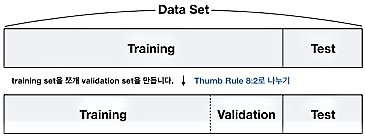

In [33]:
from IPython.display import Image
Image('images1.jpg')

In [34]:
X = train.drop(['target','anomaly'],axis=1,inplace=False)
y = train['target']

In [35]:
X_train_all, X_test, y_train_all, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

In [36]:
X_train, X_val, y_train, y_val = train_test_split(X_train_all, y_train_all, stratify=y_train_all, test_size=0.2, random_state=42)

In [43]:
print('Train 전체 데이터 크기',len(X_train_all)) # 기존 Train Set 
print('Train 분할 데이터 크기',len(X_train)) # 학습에 사용될 Train Set 
print('Valid 데이터 크기',len(X_val)) # 1차 평가 
print('Test 데이터 크기',len(X_test)) # 2차 평가 

Train 전체 데이터 크기 88344
Train 분할 데이터 크기 70675
Valid 데이터 크기 17669
Test 데이터 크기 22086


### 학습 & 결과 --> Val & Test 

#### Light GBM

In [45]:
lgbm_val = LGBMClassifier(random_state=2021)
lgbm_val.fit(X_train,y_train)      
pred = lgbm_val.predict(X_val)
pred_proba = lgbm_val.predict_proba(X_val)[:,1]
thresholds = [0.3,0.35,0.38,0.4,0.45,0.5]
get_eval_by_threshold(y_val,pred_proba.reshape(-1,1),thresholds)

임계값 0.3
[[ 544 7252]
 [ 118 9755]]
정확도:0.582885, 정밀도:0.573587, 재현율:0.988048,F1 : 0.725818, ROC AUC : 0.635195


임계값 0.35
[[ 794 7002]
 [ 217 9656]]
정확도:0.591431, 정밀도:0.579661, 재현율:0.978021,F1 : 0.727903, ROC AUC : 0.635195


임계값 0.38
[[ 960 6836]
 [ 318 9555]]
정확도:0.595110, 정밀도:0.582942, 재현율:0.967791,F1 : 0.727612, ROC AUC : 0.635195


임계값 0.4
[[1136 6660]
 [ 412 9461]]
정확도:0.599751, 정밀도:0.586874, 재현율:0.958270,F1 : 0.727937, ROC AUC : 0.635195


임계값 0.45
[[1731 6065]
 [ 906 8967]]
정확도:0.605467, 정밀도:0.596527, 재현율:0.908235,F1 : 0.720096, ROC AUC : 0.635195


임계값 0.5
[[2672 5124]
 [1738 8135]]
정확도:0.611636, 정밀도:0.613546, 재현율:0.823964,F1 : 0.703355, ROC AUC : 0.635195




In [46]:
lgbm = LGBMClassifier(random_state=2021)
lgbm.fit(X_train,y_train)      
pred = lgbm.predict(X_test)
pred_proba = lgbm.predict_proba(X_test)[:,1]
thresholds = [0.3,0.35,0.38,0.4,0.45,0.5]
get_eval_by_threshold(y_test,pred_proba.reshape(-1,1),thresholds)

임계값 0.3
[[  633  9112]
 [  166 12175]]
정확도:0.579915, 정밀도:0.571945, 재현율:0.986549,F1 : 0.724099, ROC AUC : 0.636606


임계값 0.35
[[  930  8815]
 [  300 12041]]
정확도:0.587295, 정밀도:0.577340, 재현율:0.975691,F1 : 0.725427, ROC AUC : 0.636606


임계값 0.38
[[ 1145  8600]
 [  442 11899]]
정확도:0.590600, 정밀도:0.580467, 재현율:0.964184,F1 : 0.724665, ROC AUC : 0.636606


임계값 0.4
[[ 1353  8392]
 [  573 11768]]
정확도:0.594087, 정밀도:0.583730, 재현율:0.953569,F1 : 0.724162, ROC AUC : 0.636606


임계값 0.45
[[ 2166  7579]
 [ 1147 11194]]
정확도:0.604908, 정밀도:0.596282, 재현율:0.907058,F1 : 0.719547, ROC AUC : 0.636606


임계값 0.5
[[ 3350  6395]
 [ 2205 10136]]
정확도:0.610613, 정밀도:0.613151, 재현율:0.821327,F1 : 0.702134, ROC AUC : 0.636606




In [47]:
lgbm2 = LGBMClassifier(random_state=2021,
    learning_rate =0.1,
    n_estimators=1000,
    max_depth=5,
    min_child_weight=5,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    nthread=-1,
    scale_pos_weight=1,
    seed=2019
)
lgbm2.fit(X_train,y_train)      
pred = lgbm2.predict(X_test)
pred_proba = lgbm2.predict_proba(X_test)[:,1]
thresholds = [0.3,0.35,0.38,0.4,0.45,0.5]
get_eval_by_threshold(y_test,pred_proba.reshape(-1,1),thresholds)

[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] seed is set=2019, random_state=2021 will be ignored. Current value: seed=2019
임계값 0.3
[[ 1206  8539]
 [  437 11904]]
정확도:0.593589, 정밀도:0.582302, 재현율:0.964590,F1 : 0.726208, ROC AUC : 0.644108


임계값 0.35
[[ 1667  8078]
 [  681 11660]]
정확도:0.603414, 정밀도:0.590739, 재현율:0.944818,F1 : 0.726955, ROC AUC : 0.644108


임계값 0.38
[[ 1991  7754]
 [  928 11413]]
정확도:0.606900, 정밀도:0.595451, 재현율:0.924804,F1 : 0.724451, ROC AUC : 0.644108


임계값 0.4
[[ 2262  7483]
 [ 1139 11202]]
정확도:0.609617, 정밀도:0.599518, 재현율:0.907706,F1 : 0.722104, ROC AUC : 0.644108


임계값 0.45
[[ 3084  6661]
 [ 1804 10537]]
정확도:0.616726, 정밀도:0.612688, 재현율:0.853821,F1 : 0.713430, ROC AUC : 0.644108


임계값 0.5
[[4041 5704]
 [2807 9534]]
정확도:0.614643, 정밀도:0.625673, 재현율:0.772547,F1 : 0.691396, ROC AUC : 0.644108




#### XGBoost 

In [48]:
xgb_val = XGBClassifier(random_state=2021)
xgb_val.fit(X_train,y_train)
pred = xgb_val.predict(X_val)
pred_proba = xgb_val.predict_proba(X_val)[:,1]
thresholds = [0.3,0.35,0.38,0.4,0.45,0.5]
get_eval_by_threshold(y_val,pred_proba.reshape(-1,1),thresholds)

[19:56:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
임계값 0.3
[[ 865 6931]
 [ 279 9594]]
정확도:0.591941, 정밀도:0.580575, 재현율:0.971741,F1 : 0.726873, ROC AUC : 0.631705


임계값 0.35
[[1196 6600]
 [ 488 9385]]
정확도:0.598845, 정밀도:0.587113, 재현율:0.950572,F1 : 0.725888, ROC AUC : 0.631705


임계값 0.38
[[1449 6347]
 [ 670 9203]]
정확도:0.602864, 정밀도:0.591833, 재현율:0.932138,F1 : 0.723990, ROC AUC : 0.631705


임계값 0.4
[[1622 6174]
 [ 807 9066]]
정확도:0.604901, 정밀도:0.594882, 재현율:0.918262,F1 : 0.722016, ROC AUC : 0.631705


임계값 0.45
[[2241 5555]
 [1315 8558]]
정확도:0.611183, 정밀도:0.606391, 재현율:0.866808,F1 : 0.713583, ROC AUC : 0.631705


임계값 0.5
[[3031 4765]
 [2143 7730]]
정확도:0.609033, 정밀도:0.618647, 재현율:0.782943,F1 : 0.691166, ROC AUC : 0.631705




In [50]:
xgb = XGBClassifier(random_state=2021)
xgb.fit(X_train,y_train)
pred = xgb.predict(X_test)
pred_proba = xgb.predict_proba(X_test)[:,1]
thresholds = [0.3,0.35,0.38,0.4,0.45,0.5]
get_eval_by_threshold(y_test,pred_proba.reshape(-1,1),thresholds)

[19:57:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
임계값 0.3
[[ 1076  8669]
 [  373 11968]]
정확도:0.590600, 정밀도:0.579929, 재현율:0.969776,F1 : 0.725817, ROC AUC : 0.635127


임계값 0.35
[[ 1500  8245]
 [  608 11733]]
정확도:0.599158, 정밀도:0.587296, 재현율:0.950733,F1 : 0.726074, ROC AUC : 0.635127


임계값 0.38
[[ 1823  7922]
 [  838 11503]]
정확도:0.603369, 정밀도:0.592175, 재현율:0.932096,F1 : 0.724233, ROC AUC : 0.635127


임계값 0.4
[[ 2059  7686]
 [ 1034 11307]]
정확도:0.605180, 정밀도:0.595325, 재현율:0.916214,F1 : 0.721708, ROC AUC : 0.635127


임계값 0.45
[[ 2813  6932]
 [ 1682 10659]]
정확도:0.609979, 정밀도:0.605935, 재현율:0.863706,F1 : 0.712214, ROC AUC : 0.635127


임계값 0.5
[[3867 5878]
 [2707 9634]]
정확도:0.611292, 정밀도:0.621068, 재현율:0.780650,F1 : 0.691775, ROC AUC : 0.6351

In [51]:
xgb2 = XGBClassifier(random_state=2021,
    learning_rate =0.1,
    n_estimators=1000,
    max_depth=5,
    min_child_weight=5,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    objective= 'binary:logistic',
    nthread=-1,
    scale_pos_weight=1,
    seed=2019
)
xgb2.fit(X_train,y_train)
pred = xgb2.predict(X_test)
pred_proba = xgb2.predict_proba(X_test)[:,1]
thresholds = [0.3,0.35,0.38,0.4,0.45,0.5]
get_eval_by_threshold(y_test,pred_proba.reshape(-1,1),thresholds)

[19:57:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
임계값 0.3
[[ 1254  8491]
 [  472 11869]]
정확도:0.594177, 정밀도:0.582957, 재현율:0.961754,F1 : 0.725911, ROC AUC : 0.645186


임계값 0.35
[[ 1758  7987]
 [  747 11594]]
정확도:0.604546, 정밀도:0.592105, 재현율:0.939470,F1 : 0.726396, ROC AUC : 0.645186


임계값 0.38
[[ 2139  7606]
 [ 1010 11331]]
정확도:0.609889, 정밀도:0.598352, 재현율:0.918159,F1 : 0.724535, ROC AUC : 0.645186


임계값 0.4
[[ 2389  7356]
 [ 1204 11137]]
정확도:0.612424, 정밀도:0.602228, 재현율:0.902439,F1 : 0.722384, ROC AUC : 0.645186


임계값 0.45
[[ 3189  6556]
 [ 1867 10474]]
정확도:0.618627, 정밀도:0.615032, 재현율:0.848716,F1 : 0.713221, ROC AUC : 0.645186


임계값 0.5
[[4165 5580]
 [2884 9457]]
정확도:0.616771, 정밀도:0.628915, 재현율:0.766307,F1 : 0.690847, ROC AUC : 0.6451

In [53]:
from catboost import CatBoostClassifier
cat_val = CatBoostClassifier(random_state=2021)
cat_val.fit(X_train,y_train)      
pred = cat_val.predict(X_val) 
pred_proba = cat_val.predict_proba(X_val)[:,1] 
thresholds = [0.3,0.35,0.38,0.4,0.45,0.5]
get_eval_by_threshold(y_val,pred_proba.reshape(-1,1),thresholds)

Learning rate set to 0.06347
0:	learn: 0.6905557	total: 19.2ms	remaining: 19.2s
1:	learn: 0.6884610	total: 60.7ms	remaining: 30.3s
2:	learn: 0.6865603	total: 76.2ms	remaining: 25.3s
3:	learn: 0.6847367	total: 90.6ms	remaining: 22.6s
4:	learn: 0.6831969	total: 107ms	remaining: 21.4s
5:	learn: 0.6816757	total: 128ms	remaining: 21.1s
6:	learn: 0.6804219	total: 148ms	remaining: 21s
7:	learn: 0.6791653	total: 167ms	remaining: 20.8s
8:	learn: 0.6780443	total: 189ms	remaining: 20.9s
9:	learn: 0.6770810	total: 217ms	remaining: 21.4s
10:	learn: 0.6760746	total: 237ms	remaining: 21.3s
11:	learn: 0.6752411	total: 260ms	remaining: 21.4s
12:	learn: 0.6745034	total: 281ms	remaining: 21.3s
13:	learn: 0.6737388	total: 302ms	remaining: 21.3s
14:	learn: 0.6732126	total: 323ms	remaining: 21.2s
15:	learn: 0.6726609	total: 344ms	remaining: 21.2s
16:	learn: 0.6721044	total: 364ms	remaining: 21s
17:	learn: 0.6715322	total: 386ms	remaining: 21.1s
18:	learn: 0.6710567	total: 408ms	remaining: 21.1s
19:	learn: 0

161:	learn: 0.6488204	total: 4.85s	remaining: 25.1s
162:	learn: 0.6487155	total: 4.88s	remaining: 25.1s
163:	learn: 0.6486200	total: 4.9s	remaining: 25s
164:	learn: 0.6485337	total: 4.93s	remaining: 24.9s
165:	learn: 0.6484677	total: 4.96s	remaining: 24.9s
166:	learn: 0.6483933	total: 4.98s	remaining: 24.8s
167:	learn: 0.6482775	total: 5s	remaining: 24.8s
168:	learn: 0.6481801	total: 5.03s	remaining: 24.7s
169:	learn: 0.6480607	total: 5.06s	remaining: 24.7s
170:	learn: 0.6479997	total: 5.08s	remaining: 24.6s
171:	learn: 0.6478909	total: 5.11s	remaining: 24.6s
172:	learn: 0.6478137	total: 5.13s	remaining: 24.5s
173:	learn: 0.6477389	total: 5.16s	remaining: 24.5s
174:	learn: 0.6476306	total: 5.18s	remaining: 24.4s
175:	learn: 0.6474845	total: 5.21s	remaining: 24.4s
176:	learn: 0.6473087	total: 5.23s	remaining: 24.3s
177:	learn: 0.6472434	total: 5.25s	remaining: 24.3s
178:	learn: 0.6471424	total: 5.28s	remaining: 24.2s
179:	learn: 0.6470429	total: 5.3s	remaining: 24.2s
180:	learn: 0.64695

322:	learn: 0.6342988	total: 9.16s	remaining: 19.2s
323:	learn: 0.6342348	total: 9.19s	remaining: 19.2s
324:	learn: 0.6341625	total: 9.22s	remaining: 19.2s
325:	learn: 0.6340856	total: 9.25s	remaining: 19.1s
326:	learn: 0.6340207	total: 9.28s	remaining: 19.1s
327:	learn: 0.6339287	total: 9.31s	remaining: 19.1s
328:	learn: 0.6338596	total: 9.35s	remaining: 19.1s
329:	learn: 0.6337563	total: 9.39s	remaining: 19.1s
330:	learn: 0.6336876	total: 9.42s	remaining: 19s
331:	learn: 0.6335864	total: 9.45s	remaining: 19s
332:	learn: 0.6334958	total: 9.47s	remaining: 19s
333:	learn: 0.6334442	total: 9.49s	remaining: 18.9s
334:	learn: 0.6333696	total: 9.52s	remaining: 18.9s
335:	learn: 0.6332672	total: 9.55s	remaining: 18.9s
336:	learn: 0.6331739	total: 9.58s	remaining: 18.8s
337:	learn: 0.6330810	total: 9.61s	remaining: 18.8s
338:	learn: 0.6329745	total: 9.64s	remaining: 18.8s
339:	learn: 0.6328864	total: 9.67s	remaining: 18.8s
340:	learn: 0.6328076	total: 9.69s	remaining: 18.7s
341:	learn: 0.6327

482:	learn: 0.6230243	total: 13.7s	remaining: 14.6s
483:	learn: 0.6229657	total: 13.7s	remaining: 14.6s
484:	learn: 0.6229011	total: 13.7s	remaining: 14.6s
485:	learn: 0.6228288	total: 13.8s	remaining: 14.5s
486:	learn: 0.6227840	total: 13.8s	remaining: 14.5s
487:	learn: 0.6227259	total: 13.8s	remaining: 14.5s
488:	learn: 0.6226628	total: 13.8s	remaining: 14.5s
489:	learn: 0.6226079	total: 13.9s	remaining: 14.4s
490:	learn: 0.6225608	total: 13.9s	remaining: 14.4s
491:	learn: 0.6224956	total: 13.9s	remaining: 14.4s
492:	learn: 0.6224433	total: 13.9s	remaining: 14.3s
493:	learn: 0.6223607	total: 14s	remaining: 14.3s
494:	learn: 0.6222838	total: 14s	remaining: 14.3s
495:	learn: 0.6222181	total: 14s	remaining: 14.2s
496:	learn: 0.6221755	total: 14s	remaining: 14.2s
497:	learn: 0.6221354	total: 14.1s	remaining: 14.2s
498:	learn: 0.6220728	total: 14.1s	remaining: 14.1s
499:	learn: 0.6220113	total: 14.1s	remaining: 14.1s
500:	learn: 0.6219553	total: 14.1s	remaining: 14.1s
501:	learn: 0.621907

646:	learn: 0.6133748	total: 18.1s	remaining: 9.85s
647:	learn: 0.6133317	total: 18.1s	remaining: 9.82s
648:	learn: 0.6132580	total: 18.1s	remaining: 9.79s
649:	learn: 0.6132061	total: 18.1s	remaining: 9.77s
650:	learn: 0.6131648	total: 18.2s	remaining: 9.74s
651:	learn: 0.6130901	total: 18.2s	remaining: 9.71s
652:	learn: 0.6130731	total: 18.2s	remaining: 9.69s
653:	learn: 0.6130124	total: 18.3s	remaining: 9.66s
654:	learn: 0.6129406	total: 18.3s	remaining: 9.63s
655:	learn: 0.6128867	total: 18.3s	remaining: 9.61s
656:	learn: 0.6128643	total: 18.3s	remaining: 9.57s
657:	learn: 0.6128113	total: 18.4s	remaining: 9.57s
658:	learn: 0.6127350	total: 18.5s	remaining: 9.55s
659:	learn: 0.6126614	total: 18.5s	remaining: 9.52s
660:	learn: 0.6125966	total: 18.5s	remaining: 9.49s
661:	learn: 0.6125401	total: 18.5s	remaining: 9.46s
662:	learn: 0.6124808	total: 18.6s	remaining: 9.44s
663:	learn: 0.6124423	total: 18.6s	remaining: 9.4s
664:	learn: 0.6123861	total: 18.6s	remaining: 9.38s
665:	learn: 0

806:	learn: 0.6052677	total: 22.4s	remaining: 5.37s
807:	learn: 0.6052163	total: 22.5s	remaining: 5.34s
808:	learn: 0.6051736	total: 22.5s	remaining: 5.31s
809:	learn: 0.6051404	total: 22.5s	remaining: 5.28s
810:	learn: 0.6051001	total: 22.5s	remaining: 5.25s
811:	learn: 0.6050787	total: 22.6s	remaining: 5.22s
812:	learn: 0.6050269	total: 22.6s	remaining: 5.2s
813:	learn: 0.6049545	total: 22.6s	remaining: 5.17s
814:	learn: 0.6049306	total: 22.7s	remaining: 5.14s
815:	learn: 0.6048723	total: 22.7s	remaining: 5.12s
816:	learn: 0.6048358	total: 22.7s	remaining: 5.08s
817:	learn: 0.6047872	total: 22.7s	remaining: 5.06s
818:	learn: 0.6047221	total: 22.8s	remaining: 5.03s
819:	learn: 0.6046760	total: 22.8s	remaining: 5s
820:	learn: 0.6046437	total: 22.8s	remaining: 4.97s
821:	learn: 0.6045920	total: 22.8s	remaining: 4.94s
822:	learn: 0.6045490	total: 22.8s	remaining: 4.91s
823:	learn: 0.6044880	total: 22.9s	remaining: 4.89s
824:	learn: 0.6044404	total: 22.9s	remaining: 4.86s
825:	learn: 0.60

966:	learn: 0.5976889	total: 26.6s	remaining: 907ms
967:	learn: 0.5976229	total: 26.6s	remaining: 879ms
968:	learn: 0.5975814	total: 26.6s	remaining: 852ms
969:	learn: 0.5975318	total: 26.6s	remaining: 824ms
970:	learn: 0.5974778	total: 26.7s	remaining: 796ms
971:	learn: 0.5974337	total: 26.7s	remaining: 769ms
972:	learn: 0.5974056	total: 26.7s	remaining: 741ms
973:	learn: 0.5973726	total: 26.7s	remaining: 713ms
974:	learn: 0.5973106	total: 26.7s	remaining: 686ms
975:	learn: 0.5972809	total: 26.8s	remaining: 658ms
976:	learn: 0.5972039	total: 26.8s	remaining: 631ms
977:	learn: 0.5971633	total: 26.8s	remaining: 603ms
978:	learn: 0.5970962	total: 26.8s	remaining: 576ms
979:	learn: 0.5970286	total: 26.9s	remaining: 548ms
980:	learn: 0.5969824	total: 26.9s	remaining: 521ms
981:	learn: 0.5969329	total: 26.9s	remaining: 493ms
982:	learn: 0.5968966	total: 26.9s	remaining: 466ms
983:	learn: 0.5968598	total: 27s	remaining: 439ms
984:	learn: 0.5968277	total: 27s	remaining: 411ms
985:	learn: 0.59

In [54]:
cat = CatBoostClassifier(random_state=2021)
cat.fit(X_train,y_train)      
pred = cat.predict(X_test) 
pred_proba = cat.predict_proba(X_test)[:,1] 
thresholds = [0.3,0.35,0.38,0.4,0.45,0.5]
get_eval_by_threshold(y_test,pred_proba.reshape(-1,1),thresholds)

Learning rate set to 0.06347
0:	learn: 0.6905557	total: 19.6ms	remaining: 19.6s
1:	learn: 0.6884610	total: 42.4ms	remaining: 21.2s
2:	learn: 0.6865603	total: 65ms	remaining: 21.6s
3:	learn: 0.6847367	total: 87.4ms	remaining: 21.8s
4:	learn: 0.6831969	total: 112ms	remaining: 22.3s
5:	learn: 0.6816757	total: 137ms	remaining: 22.7s
6:	learn: 0.6804219	total: 167ms	remaining: 23.7s
7:	learn: 0.6791653	total: 193ms	remaining: 23.9s
8:	learn: 0.6780443	total: 228ms	remaining: 25.1s
9:	learn: 0.6770810	total: 252ms	remaining: 24.9s
10:	learn: 0.6760746	total: 270ms	remaining: 24.3s
11:	learn: 0.6752411	total: 292ms	remaining: 24s
12:	learn: 0.6745034	total: 313ms	remaining: 23.8s
13:	learn: 0.6737388	total: 336ms	remaining: 23.7s
14:	learn: 0.6732126	total: 357ms	remaining: 23.4s
15:	learn: 0.6726609	total: 382ms	remaining: 23.5s
16:	learn: 0.6721044	total: 411ms	remaining: 23.8s
17:	learn: 0.6715322	total: 441ms	remaining: 24.1s
18:	learn: 0.6710567	total: 466ms	remaining: 24.1s
19:	learn: 0

162:	learn: 0.6487155	total: 4.74s	remaining: 24.3s
163:	learn: 0.6486200	total: 4.78s	remaining: 24.4s
164:	learn: 0.6485337	total: 4.81s	remaining: 24.3s
165:	learn: 0.6484677	total: 4.83s	remaining: 24.3s
166:	learn: 0.6483933	total: 4.86s	remaining: 24.2s
167:	learn: 0.6482775	total: 4.88s	remaining: 24.2s
168:	learn: 0.6481801	total: 4.91s	remaining: 24.1s
169:	learn: 0.6480607	total: 4.93s	remaining: 24.1s
170:	learn: 0.6479997	total: 4.96s	remaining: 24s
171:	learn: 0.6478909	total: 4.98s	remaining: 24s
172:	learn: 0.6478137	total: 5.03s	remaining: 24s
173:	learn: 0.6477389	total: 5.07s	remaining: 24.1s
174:	learn: 0.6476306	total: 5.11s	remaining: 24.1s
175:	learn: 0.6474845	total: 5.14s	remaining: 24.1s
176:	learn: 0.6473087	total: 5.18s	remaining: 24.1s
177:	learn: 0.6472434	total: 5.21s	remaining: 24.1s
178:	learn: 0.6471424	total: 5.23s	remaining: 24s
179:	learn: 0.6470429	total: 5.26s	remaining: 24s
180:	learn: 0.6469577	total: 5.29s	remaining: 23.9s
181:	learn: 0.6468596	

329:	learn: 0.6337563	total: 9.04s	remaining: 18.3s
330:	learn: 0.6336876	total: 9.07s	remaining: 18.3s
331:	learn: 0.6335864	total: 9.09s	remaining: 18.3s
332:	learn: 0.6334958	total: 9.12s	remaining: 18.3s
333:	learn: 0.6334442	total: 9.14s	remaining: 18.2s
334:	learn: 0.6333696	total: 9.17s	remaining: 18.2s
335:	learn: 0.6332672	total: 9.21s	remaining: 18.2s
336:	learn: 0.6331739	total: 9.24s	remaining: 18.2s
337:	learn: 0.6330810	total: 9.28s	remaining: 18.2s
338:	learn: 0.6329745	total: 9.3s	remaining: 18.1s
339:	learn: 0.6328864	total: 9.32s	remaining: 18.1s
340:	learn: 0.6328076	total: 9.34s	remaining: 18.1s
341:	learn: 0.6327113	total: 9.37s	remaining: 18s
342:	learn: 0.6326213	total: 9.39s	remaining: 18s
343:	learn: 0.6325503	total: 9.41s	remaining: 17.9s
344:	learn: 0.6324781	total: 9.43s	remaining: 17.9s
345:	learn: 0.6324066	total: 9.45s	remaining: 17.9s
346:	learn: 0.6323361	total: 9.46s	remaining: 17.8s
347:	learn: 0.6322528	total: 9.49s	remaining: 17.8s
348:	learn: 0.632

493:	learn: 0.6223607	total: 13.2s	remaining: 13.5s
494:	learn: 0.6222838	total: 13.2s	remaining: 13.5s
495:	learn: 0.6222181	total: 13.3s	remaining: 13.5s
496:	learn: 0.6221755	total: 13.3s	remaining: 13.5s
497:	learn: 0.6221354	total: 13.3s	remaining: 13.4s
498:	learn: 0.6220728	total: 13.4s	remaining: 13.4s
499:	learn: 0.6220113	total: 13.4s	remaining: 13.4s
500:	learn: 0.6219553	total: 13.4s	remaining: 13.4s
501:	learn: 0.6219076	total: 13.5s	remaining: 13.4s
502:	learn: 0.6218440	total: 13.5s	remaining: 13.3s
503:	learn: 0.6217961	total: 13.5s	remaining: 13.3s
504:	learn: 0.6217430	total: 13.6s	remaining: 13.3s
505:	learn: 0.6216726	total: 13.6s	remaining: 13.3s
506:	learn: 0.6215954	total: 13.6s	remaining: 13.2s
507:	learn: 0.6215314	total: 13.6s	remaining: 13.2s
508:	learn: 0.6214473	total: 13.7s	remaining: 13.2s
509:	learn: 0.6213840	total: 13.7s	remaining: 13.2s
510:	learn: 0.6213474	total: 13.7s	remaining: 13.1s
511:	learn: 0.6212842	total: 13.8s	remaining: 13.1s
512:	learn: 

659:	learn: 0.6126614	total: 18.3s	remaining: 9.42s
660:	learn: 0.6125966	total: 18.3s	remaining: 9.39s
661:	learn: 0.6125401	total: 18.3s	remaining: 9.36s
662:	learn: 0.6124808	total: 18.4s	remaining: 9.34s
663:	learn: 0.6124423	total: 18.4s	remaining: 9.31s
664:	learn: 0.6123861	total: 18.4s	remaining: 9.28s
665:	learn: 0.6123467	total: 18.4s	remaining: 9.25s
666:	learn: 0.6122978	total: 18.5s	remaining: 9.22s
667:	learn: 0.6122321	total: 18.5s	remaining: 9.19s
668:	learn: 0.6121766	total: 18.5s	remaining: 9.16s
669:	learn: 0.6121254	total: 18.6s	remaining: 9.14s
670:	learn: 0.6120822	total: 18.6s	remaining: 9.11s
671:	learn: 0.6120517	total: 18.6s	remaining: 9.08s
672:	learn: 0.6119945	total: 18.6s	remaining: 9.05s
673:	learn: 0.6119423	total: 18.7s	remaining: 9.02s
674:	learn: 0.6118845	total: 18.7s	remaining: 9s
675:	learn: 0.6118162	total: 18.7s	remaining: 8.97s
676:	learn: 0.6117844	total: 18.7s	remaining: 8.94s
677:	learn: 0.6117395	total: 18.8s	remaining: 8.91s
678:	learn: 0.6

824:	learn: 0.6044404	total: 23.3s	remaining: 4.94s
825:	learn: 0.6044015	total: 23.3s	remaining: 4.92s
826:	learn: 0.6043422	total: 23.4s	remaining: 4.89s
827:	learn: 0.6042976	total: 23.4s	remaining: 4.86s
828:	learn: 0.6042540	total: 23.4s	remaining: 4.83s
829:	learn: 0.6042137	total: 23.5s	remaining: 4.8s
830:	learn: 0.6041582	total: 23.5s	remaining: 4.78s
831:	learn: 0.6040881	total: 23.5s	remaining: 4.75s
832:	learn: 0.6040567	total: 23.6s	remaining: 4.73s
833:	learn: 0.6040186	total: 23.6s	remaining: 4.7s
834:	learn: 0.6039856	total: 23.7s	remaining: 4.68s
835:	learn: 0.6039359	total: 23.7s	remaining: 4.66s
836:	learn: 0.6039011	total: 23.8s	remaining: 4.63s
837:	learn: 0.6038499	total: 23.9s	remaining: 4.61s
838:	learn: 0.6037928	total: 23.9s	remaining: 4.59s
839:	learn: 0.6037468	total: 24s	remaining: 4.58s
840:	learn: 0.6036715	total: 24.1s	remaining: 4.55s
841:	learn: 0.6036124	total: 24.1s	remaining: 4.53s
842:	learn: 0.6035720	total: 24.2s	remaining: 4.5s
843:	learn: 0.603

986:	learn: 0.5967684	total: 27.9s	remaining: 368ms
987:	learn: 0.5967224	total: 28s	remaining: 340ms
988:	learn: 0.5966731	total: 28s	remaining: 311ms
989:	learn: 0.5966136	total: 28s	remaining: 283ms
990:	learn: 0.5965595	total: 28s	remaining: 255ms
991:	learn: 0.5965086	total: 28.1s	remaining: 226ms
992:	learn: 0.5964693	total: 28.1s	remaining: 198ms
993:	learn: 0.5964289	total: 28.1s	remaining: 170ms
994:	learn: 0.5963887	total: 28.1s	remaining: 141ms
995:	learn: 0.5963524	total: 28.1s	remaining: 113ms
996:	learn: 0.5963177	total: 28.2s	remaining: 84.7ms
997:	learn: 0.5962674	total: 28.2s	remaining: 56.5ms
998:	learn: 0.5962374	total: 28.2s	remaining: 28.2ms
999:	learn: 0.5962017	total: 28.2s	remaining: 0us
임계값 0.3
[[  823  8922]
 [  242 12099]]
정확도:0.585077, 정밀도:0.575567, 재현율:0.980391,F1 : 0.725316, ROC AUC : 0.644121


임계값 0.35
[[ 1194  8551]
 [  431 11910]]
정확도:0.593317, 정밀도:0.582083, 재현율:0.965076,F1 : 0.726175, ROC AUC : 0.644121


임계값 0.38
[[ 1496  8249]
 [  627 11714]]
정확도:0.

In [55]:
from ngboost import NGBClassifier
from ngboost.distns import Bernoulli

In [57]:
ngb_val = NGBClassifier(Dist=Bernoulli,random_state=2021)
ngb_val.fit(X_train,y_train)      
pred = ngb_val.predict(X_val)
pred_proba = ngb_val.predict_proba(X_val)[:,1]
thresholds = [0.3,0.35,0.38,0.4,0.45,0.5]
get_eval_by_threshold(y_val,pred_proba.reshape(-1,1),thresholds)

[iter 0] loss=0.6862 val_loss=0.0000 scale=2.0000 norm=4.0000
[iter 100] loss=0.6677 val_loss=0.0000 scale=2.0000 norm=3.9601
[iter 200] loss=0.6630 val_loss=0.0000 scale=2.0000 norm=3.9535
[iter 300] loss=0.6602 val_loss=0.0000 scale=1.0000 norm=1.9746
[iter 400] loss=0.6580 val_loss=0.0000 scale=2.0000 norm=3.9466
임계값 0.3
[[ 449 7347]
 [  99 9774]]
정확도:0.578584, 정밀도:0.570878, 재현율:0.989973,F1 : 0.724161, ROC AUC : 0.621749


임계값 0.35
[[ 595 7201]
 [ 167 9706]]
정확도:0.582998, 정밀도:0.574082, 재현율:0.983085,F1 : 0.724869, ROC AUC : 0.621749


임계값 0.38
[[ 706 7090]
 [ 216 9657]]
정확도:0.586507, 정밀도:0.576641, 재현율:0.978122,F1 : 0.725545, ROC AUC : 0.621749


임계값 0.4
[[ 834 6962]
 [ 297 9576]]
정확도:0.589167, 정밀도:0.579030, 재현율:0.969918,F1 : 0.725152, ROC AUC : 0.621749


임계값 0.45
[[1249 6547]
 [ 568 9305]]
정확도:0.597317, 정밀도:0.586992, 재현율:0.942469,F1 : 0.723421, ROC AUC : 0.621749


임계값 0.5
[[1969 5827]
 [1185 8688]]
정확도:0.603147, 정밀도:0.598553, 재현율:0.879976,F1 : 0.712482, ROC AUC : 0.621749




In [58]:
ngb = NGBClassifier(Dist=Bernoulli,random_state=2021)
ngb.fit(X_train,y_train)      
pred = ngb.predict(X_test)
pred_proba = ngb.predict_proba(X_test)[:,1]
thresholds = [0.3,0.35,0.38,0.4,0.45,0.5]
get_eval_by_threshold(y_test,pred_proba.reshape(-1,1),thresholds)

[iter 0] loss=0.6862 val_loss=0.0000 scale=2.0000 norm=4.0000
[iter 100] loss=0.6677 val_loss=0.0000 scale=2.0000 norm=3.9601
[iter 200] loss=0.6630 val_loss=0.0000 scale=2.0000 norm=3.9535
[iter 300] loss=0.6602 val_loss=0.0000 scale=1.0000 norm=1.9746
[iter 400] loss=0.6580 val_loss=0.0000 scale=2.0000 norm=3.9466
임계값 0.3
[[  545  9200]
 [  145 12196]]
정확도:0.576881, 정밀도:0.570013, 재현율:0.988251,F1 : 0.723004, ROC AUC : 0.619454


임계값 0.35
[[  708  9037]
 [  214 12127]]
정확도:0.581137, 정밀도:0.573001, 재현율:0.982659,F1 : 0.723892, ROC AUC : 0.619454


임계값 0.38
[[  838  8907]
 [  295 12046]]
정확도:0.583356, 정밀도:0.574906, 재현율:0.976096,F1 : 0.723614, ROC AUC : 0.619454


임계값 0.4
[[  993  8752]
 [  403 11938]]
정확도:0.585484, 정밀도:0.576994, 재현율:0.967345,F1 : 0.722836, ROC AUC : 0.619454


임계값 0.45
[[ 1522  8223]
 [  796 11545]]
정확도:0.591642, 정밀도:0.584025, 재현율:0.935500,F1 : 0.719113, ROC AUC : 0.619454


임계값 0.5
[[ 2451  7294]
 [ 1536 10805]]
정확도:0.600199, 정밀도:0.596994, 재현율:0.875537,F1 : 0.709921, ROC 

### Test 데이터 조정 

In [36]:
for i in list1:
    test[i] = encoder.fit_transform(test[i])

In [37]:
final_pred = cat.predict_proba(test)[:,1]
final_pred

array([0.59112937, 0.63088027, 0.45998546, ..., 0.62672201, 0.50625225,
       0.51575523])

In [38]:
threshold=0.35
final_pred = np.where(final_pred >= threshold , 1, 0)
final_pred

array([1, 1, 1, ..., 1, 1, 1])

In [39]:
sample_submission = pd.read_csv("데이콘/sample_submission.csv")
sample_submission['target'] = final_pred

In [40]:
test.shape

(46404, 52)

In [41]:
sample_submission['target'].value_counts()

1    37593
0     8811
Name: target, dtype: int64

In [42]:
sample_submission.to_csv('s_submission.csv', index=False, encoding='utf-8-sig')